# Differentiable FIR Filters

In this chapter, we will implement differentiable FIR filters in three ways, and optimise their parameters.

First, we will highlight the connection between FIR filters and one dimensional convolutional neural network layers, by showing that we can directly optimise a filter by simply convolving a signal with its impulse response. Then, we will implement the FFT convolution algorithm using only differentiable operations.

Next, we will introduce the frequency sampling method for designing linear phase FIR filters, and implement this differentiably too. Finally, we tie together these techniques to implement a fully differentiable time-varying FIR filter which we use to shape a white noise signal to match an audio signal.

To start, we make a few imports...

In [1]:
from functools import partial
from typing import Callable, Optional, Union

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchaudio

...set some useful globals, seed the PRNG...

In [2]:
SAMPLE_RATE = 16000
EPSILON = 1e-7

SEED = 420
np.random.seed(SEED)
torch.manual_seed(SEED)

...and define some utility functions to avoid `nan` or `inf` gradients caused by undefined operations (e.g. $\log 0$ or $\frac{d}{dx}|x|$ when $x=0$).

In [3]:
def safe_log(x: Union[np.ndarray, torch.Tensor], base: Optional[float] = None, eps: float = EPSILON):
    denom = 1 if base is None else np.log(base)
    if isinstance(x, np.ndarray):
        return np.log(np.clip(x, eps, None)) / denom
    elif isinstance(x, torch.Tensor):
        return torch.log(torch.clamp(x, min=eps)) / denom

def safe_abs(x: torch.Tensor, eps: float = EPSILON) -> torch.Tensor:
    return (x.real ** 2 + x.imag ** 2).clamp(min=eps).sqrt()

## `nn.Conv1D` $\approx$ FIR

As we have discussed, applying a discrete time FIR filter to a signal is equivalent to convolving the signal $x[n]$ with the impulse response of the filter $h[n]$:

$$
y[n] = (x\ast h)[n] = \sum_{m=-\infty}^\infty x[n-m]h[m].
$$

Of course, neither our impulse response nor our signal is infinitely long, meaning they are implicitly padded by zeros and we can truncate the sum. Let us assume that our impulse response has length $M$, then our signal $y[n]$ is given by:

$$
y[n] = \sum_{m=0}^M x[n-m]h[m].
$$

This, you might notice, is very close to the way that 1D convolutional layers are computed in neural networks\*. So close, in fact, that convolutional layers effectively _are_ differentiable FIR filters!

\* Confusingly, these layers perform *cross-correlation* instead of convolution, which is very similar but the impulse response (which, in this context, is referred to as a kernel) is reversed. In fact, if we swap $x[n-m]$ for $x[n+m]$, we have a 1D convolutional layer.

Let's start by exploring this connection a little and creating some very simple FIR filters. We start by creating a white noise signal $x$ of length $N$.

First, however, let's write a function to help us plot signals.

In [4]:
PLOT_COLORS = ["black", "red", "green", "blue", "orange"]
PLOT_LINESTYLES = ["solid", "dashed", "dotted", "dashdot"]

def plot_signal_and_spectrum(
    signal: Union[torch.Tensor, list[torch.Tensor]],
    labels: Optional[list[str]] = None,
):
    """We'll be wanting to plot some signals, so let's make that nice and easy...
    """
    if not isinstance(signal, list):
        signal = [signal]

    signal = [s.detach().numpy() for s in signal]

    fig, ax = plt.subplots(2, 1, figsize=(6, 4))
    t = np.arange(signal[0].size) / SAMPLE_RATE

    if labels is None:
        labels = [None] * len(signal)

    for s, color, linestyle, label in zip(signal, PLOT_COLORS, PLOT_LINESTYLES, labels):
        # compute the log magnitude spectrum of the signal
        spectrum = np.fft.rfft(s, norm="forward")
        spectrum = np.abs(spectrum)
        spectrum = 20 * safe_log(spectrum, 10)
        
        ax[0].plot(t, s, color=color, linestyle=linestyle, linewidth=1.0, label=label)
    
        f = SAMPLE_RATE * np.arange(s.size // 2 + 1) / s.size
        ax[1].plot(f, spectrum, color=color, linestyle=linestyle, linewidth=1.0, label=label)
    
    ax[0].set_title("Signal")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Amplitude")
    ax[1].set_xscale("log")
    ax[1].set_title("Spectrum")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_ylabel("Magnitude (dB)")

    if any([l is not None for l in labels]):
        ax[0].legend()

    fig.tight_layout()

And now we create and visualise the signal:

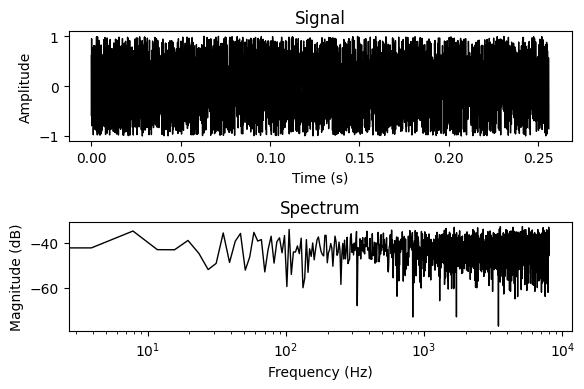

In [5]:
N = 4096
x = torch.empty(N).uniform_(-1, 1)
plot_signal_and_spectrum(x)

Now let's create a very simple filter, the one given by the difference equation:

$$
y[n] = x[n] + x[n-1] + x[n-2].
$$

This is a simple moving average filter, which attenuates the high frequencies. It is equivalent to the impulse response: $\mathbf{h} = \begin{bmatrix}1 & 1 & 1\end{bmatrix}^T$.

Again, we first create a helper function to plot the filter response as a Bode plot.

In [6]:
def bode_plot(
    impulse_response: Union[torch.Tensor, list[torch.Tensor]],
    N: int,
    labels: Optional[list[str]] = None
):
    """We'll be wanting to look at some filters too... so let's make some Bode plots
    """

    if not isinstance(impulse_response, list):
        impulse_response = [impulse_response]
    hs = [i.detach().numpy() for i in impulse_response]

    # evaluate the z-transform at roots of unity by zero padding the impulse
    # response and taking the DFT
    hs_ = [np.pad(h, (0, N - h.size)) for h in hs]
    Hs = [np.fft.rfft(h_)[:-1] for h_ in hs_]
    
    H_mags = [np.abs(H) for H in Hs]
    H_mags = [20 * safe_log(H_mag, 10) for H_mag in H_mags]
    
    H_phases = [np.angle(H) % (1 * np.pi) for H in Hs]

    fig, ax = plt.subplots(3, 1, figsize=(6, 6))
    f = SAMPLE_RATE * np.arange(N // 2) / N

    if labels is None:
        labels = [None] * len(hs)
    
    for H_mag, H_phase, h, label, color, linestyle in zip(
        H_mags, H_phases, hs, labels, PLOT_COLORS, PLOT_LINESTYLES
    ):
        ax[0].plot(f, H_mag, linewidth=1.0, label=label, color=color, linestyle=linestyle)
        ax[0].set_xscale("log")
        ax[0].set_title("Magnitude")
        ax[0].set_xlabel("Frequency (Hz)")
        ax[0].set_ylabel("dB")
        
        ax[1].plot(f, H_phase, linewidth=1.0, label=label, color=color, linestyle=linestyle)
        ax[1].set_xscale("log")
        ax[1].set_title("Phase")
        ax[1].set_xlabel("Frequency (Hz)")
        ax[1].set_ylabel("radians")
        
        _, stem, _ = ax[2].stem(h, basefmt="black", label=label, linefmt=color)
        plt.setp(stem, "linewidth", 1.0)
        plt.setp(stem, "linestyle", linestyle)
        ax[2].set_title("Impulse Response")
        ax[2].set_xlabel("Sample Index")
        ax[2].set_ylabel("Amplitude")
        fig.tight_layout()

    if any([l is not None for l in labels]):
        ax[0].legend()

And then we define our filter...

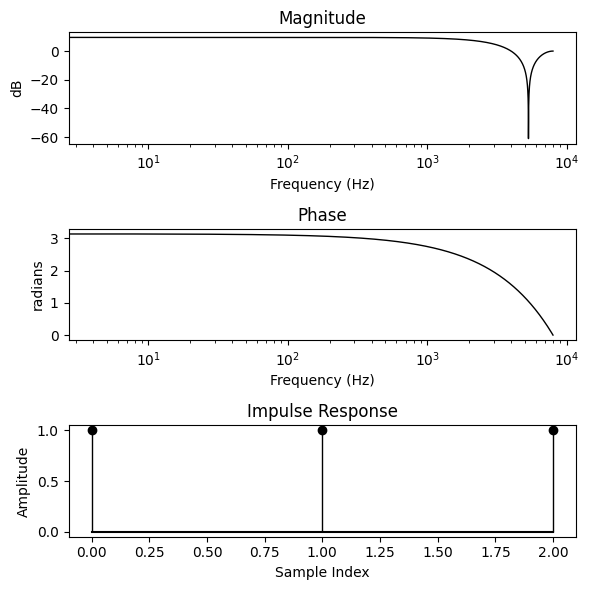

In [7]:
h = torch.tensor([1.0, 1.0, 1.0])

bode_plot(h, N)

We will now use PyTorch's `nn.functional.conv1d` to apply our impulse response (aka kernel) to our signal. Note that [this function expects](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv1d.html) an input tensor with the shape `[batch, in_channels, time]`, and a kernel tensor with shape `[out_channels, in_channels, length]`. Now, as we are operating with a batch size of 1, and on only a single channel, we will just add placeholder dimensions.

In [8]:
x_ = x[None, None, :]  # unsqueeze to [batch, in_channels, time]
h_ = h[None, None, :]  # unsqueeze to [out_channels, in_channels, length]

print(f"input shape: {x_.shape}\nkernel shape: {h_.shape}")

input shape: torch.Size([1, 1, 4096])
kernel shape: torch.Size([1, 1, 3])


Our tensors are correctly shaped... let's perform the convolution! Note that we call `torch.Tensor.flip()` in order to reverse the impulse response. This makes the `nn.functional.conv1d`'s cross-corelation operation into a convolution. We also pad the signal *causally*, rather than relying on PyTorch's `same` padding.

In [9]:
x_padded = nn.functional.pad(x_, (h_.shape[-1] - 1, 0))
y_ = nn.functional.conv1d(
    x_padded,
    h_.flip(-1),
    padding="same"
)
y = y_.squeeze()

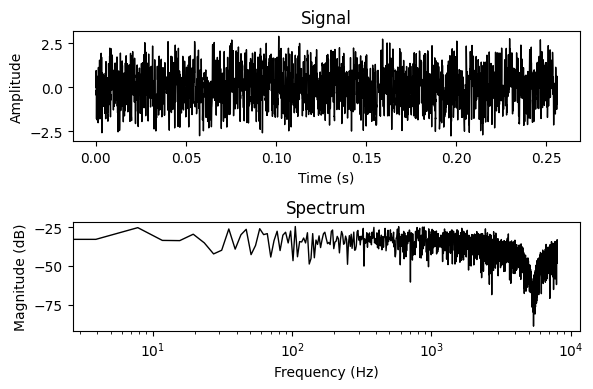

In [10]:
plot_signal_and_spectrum(y)

### Optimising our simple FIR filter

Now, let's try to optimise the impulse response of our direct convolution filter so that it matches a target filter's response. To do so, let's first wrap our filtering code in a nice tidy function:

In [11]:
@torch.jit.script
def apply_conv1d_fir(input_signal: torch.Tensor, impulse_response: torch.Tensor):
    input_signal = nn.functional.pad(input_signal, (impulse_response.shape[-1] - 1, 0))
    input_signal = input_signal[None, None, :]  # unsqueeze to [batch, in_channels, time]
    impulse_response = impulse_response[None, None, :]  # unsqueeze to [out_channels, in_channels, length]
    output_signal = nn.functional.conv1d(
        input_signal,
        impulse_response.flip(-1),
    )
    return output_signal.squeeze()

We then define our predicted filter's impulse response as a tensor. Note that we set `requires_grad=True`. This ensures that PyTorch records operations on this tensor in its computation graph so that we can perform backpropogation to recover its gradient.

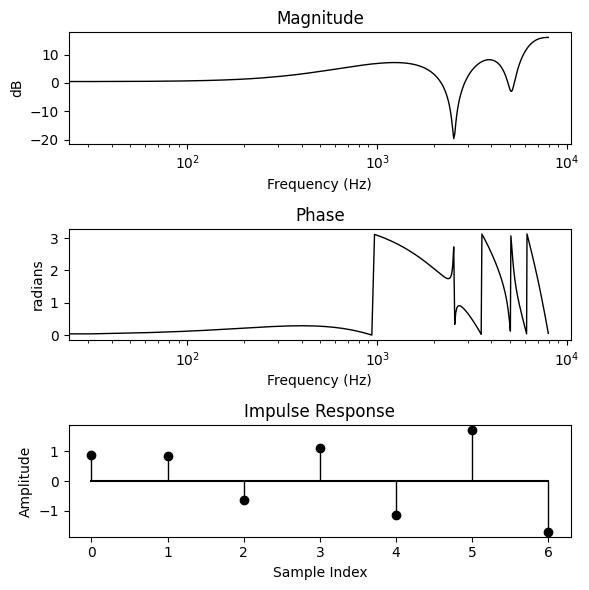

In [12]:
N = 512
M = 7
predicted_impulse_response = torch.randn(M, requires_grad=True)

bode_plot(predicted_impulse_response, N)

We define a synthetic target signal by creating a target filter... Let's make it something very obvious, alternating 1s and -1s.

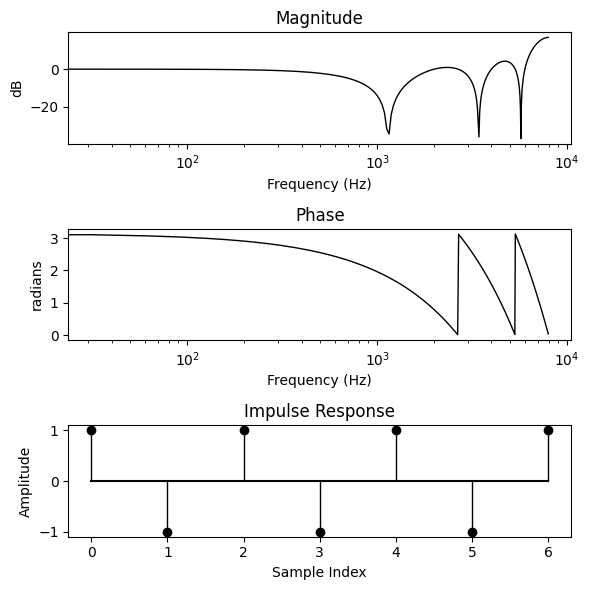

In [13]:
target_filter = torch.Tensor([1, -1, 1, -1, 1, -1, 1])
bode_plot(target_filter, N)

We define our target signal by applying the filter to some white noise.

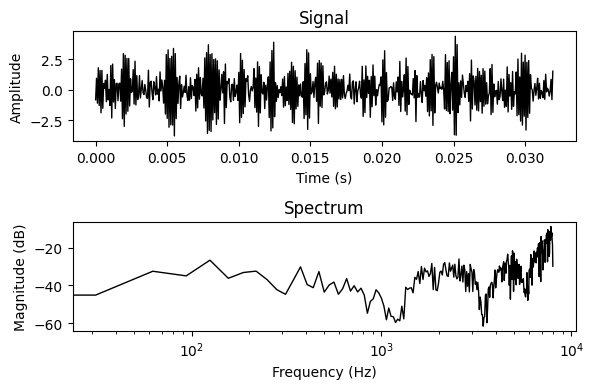

In [14]:
input_signal = torch.empty(N).uniform_(-1, 1)
target_signal = apply_conv1d_fir(input_signal, target_filter)

plot_signal_and_spectrum(target_signal)

Now we write a simple optimisation loop. Note that we are *applying the filter* to the noise signal in order to compute our loss. We are then taking a loss function between our target signal and the noise signal filtered by our predicted filter. This means there's no reason that we need to use $L^2$ loss --- we can use *any* loss function we can define on the signal.

In [15]:
optimizer = torch.optim.Adam([predicted_impulse_response], lr=1e-3)
criterion = nn.MSELoss()

steps = 7000
interval = 1000

for step in range(steps):
    predicted_signal = apply_conv1d_fir(input_signal, predicted_impulse_response)
    loss = criterion(target_signal, predicted_signal)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if step % interval == 0:
        print(f"Step {step}: loss {loss.item():.4f}")

Step 0: loss 9.8862
Step 1000: loss 3.6374
Step 2000: loss 1.0242
Step 3000: loss 0.1884
Step 4000: loss 0.0172
Step 5000: loss 0.0004
Step 6000: loss 0.0000


Cool! That converged quickly. Let's plot the learnt response...

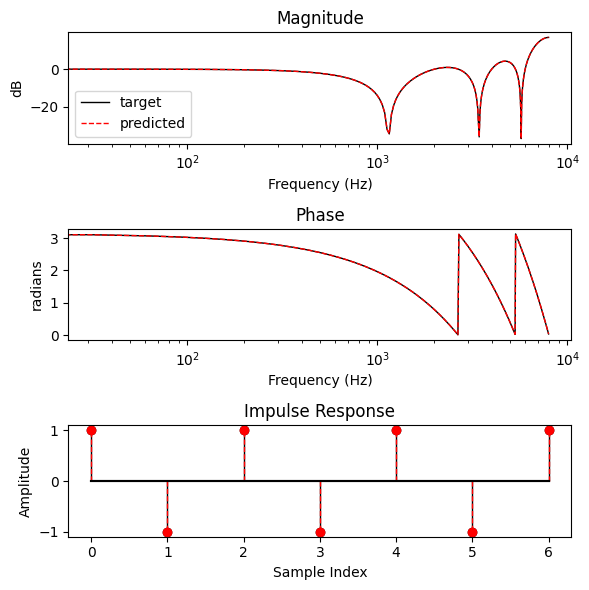

In [16]:
bode_plot([target_filter, predicted_impulse_response], N, labels=["target", "predicted"])

A perfect fit!

## FFT Convolution

For longer impulse responses, the quadratic time complexity of naive convolution becomes a bottleneck, and so efficient convolution algorithms are often preferred. Perhaps the best known is FFT convolution, which is a result of the discrete convolution theorem — the discrete Fourier transform of the circular convolution of two periodic signals is equal to the element-wise product of the Fourier transforms of the individual signals:

$$
\mathcal{F}\{u\ast v\}[k] = \mathcal{F}\{u\}[k] \cdot \mathcal{F}\{v\}[k]
$$

Computationally, this allows us to perform convolution in $\mathcal{O}(n\log n)$ time in lieu of $\mathcal{O}(n^2)$. Let's try implementing it.

In [17]:
@torch.jit.script
def apply_fft_fir(input_signal: torch.Tensor, impulse_response: torch.Tensor):
    N = input_signal.shape[-1]
    L = impulse_response.shape[-1]
    
    input_signal = nn.functional.pad(input_signal, (0, L - 1))
    impulse_response = nn.functional.pad(impulse_response, (0, N - 1))

    X = torch.fft.rfft(input_signal)
    H = torch.fft.rfft(impulse_response)
    y = torch.fft.irfft(X * H)

    return y[:-(L - 1)]

Notice that we zero pad the lengths of the input signal (starting length $N$) and the impulse response (starting length $L$) to $N+L-1$. This is because frequency domain multiplication is equivalent to *circular* convolution. The zero padding is hence necessary to avoid the tail of the convolved signal "wrapping" to the start.

Now let's apply it to a signal...

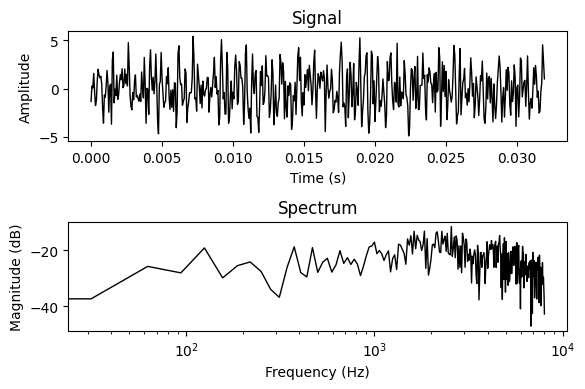

In [18]:
h = torch.randn(11)
y = apply_fft_fir(input_signal, h)
plot_signal_and_spectrum(y)

...and compare to our time-domain implementation:

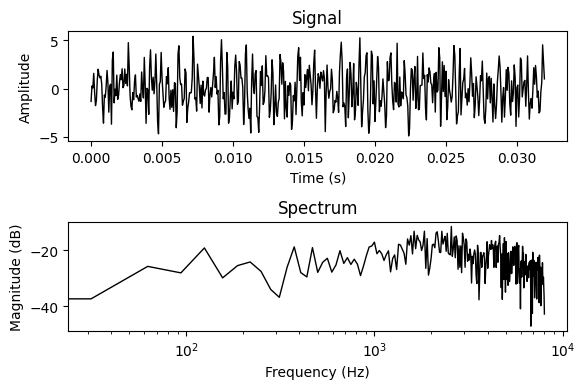

In [19]:
y_ = apply_conv1d_fir(input_signal, h)
plot_signal_and_spectrum(y_)

Looks close! Let's check the error...

In [20]:
mse = (y - y_).square().mean().item()
print(f"Mean squared error between nn.functional.conv1d and FFT convolution is: {mse}")

Mean squared error between nn.functional.conv1d and FFT convolution is: 2.0662443110663897e-13


The question is... is it really faster than directly applying the convolution? Let's run a small experiment to find out...

IR length L = 4: FFT time 0.334, Conv1D time 0.046
IR length L = 8: FFT time 0.321, Conv1D time 0.078
IR length L = 16: FFT time 0.305, Conv1D time 0.099
IR length L = 32: FFT time 0.469, Conv1D time 0.075
IR length L = 64: FFT time 0.417, Conv1D time 0.066
IR length L = 128: FFT time 0.402, Conv1D time 0.146
IR length L = 256: FFT time 0.327, Conv1D time 0.358
IR length L = 512: FFT time 0.497, Conv1D time 0.379
IR length L = 1024: FFT time 0.533, Conv1D time 0.242
IR length L = 2048: FFT time 0.985, Conv1D time 1.599
IR length L = 4096: FFT time 1.443, Conv1D time 2.994
IR length L = 8192: FFT time 3.162, Conv1D time 7.588


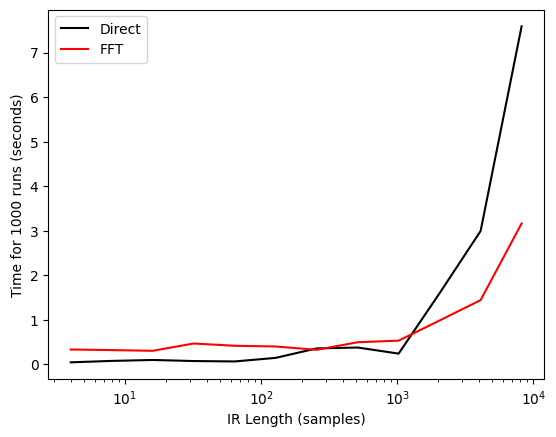

In [21]:
from timeit import timeit

n_trials = 1000

N = 1024
x = torch.empty(N)

ir_sizes = [2 ** n for n in range(2, 14)]
fft_times = []
conv1d_times = []

for ir_size in ir_sizes:
    h = torch.empty(ir_size)

    fft_time = timeit(lambda: apply_fft_fir(x, h), number=n_trials)
    conv1d_time = timeit(lambda: apply_conv1d_fir(x, h), number=n_trials)

    fft_times.append(fft_time)
    conv1d_times.append(conv1d_time)

    print(f"IR length L = {ir_size}: FFT time {fft_time:.3f}, Conv1D time {conv1d_time:.3f}")

plt.plot(ir_sizes, conv1d_times, color="black", label="Direct")
plt.plot(ir_sizes, fft_times, color="red", label="FFT")
plt.ylabel(f"Time for {n_trials} runs (seconds)")
plt.xlabel("IR Length (samples)")
plt.xscale("log")
plt.legend()

As expected, for larger impulse responses FFT convolution is clearly faster. But interestingly, for responses below roughly 1000 samples, the direct convolution approach wins out.

There are a number of factors at play here, and to detail them all would be well beyond the scope of this tutorial. However, it suffices to acknowledge a few points:

1. This is a single implementation being tested under unscientific conditions on a particular CPU.
2. Convolutions are conditionally dispatched to different MKLDNN (CPU) and cuDNN (GPU) kernels depending on various factors including kernel size. These include other fast-convolution algorithms such as Winograd.
3. We can expect a bigger relative speed up for FFT convolutions on a GPU thanks to hardware-level parallelisation of matrix multiplications.

For more background, and a performance comparison of cuDNN convolution algorithms, see the work of Jordà et al. {cite}`jorda_performance_2019`.

## Linear Phase Filter Design by Frequency Sampling

While we can directly optimise the impulse response, we may wish instead to provide a frequency response from which we derive a filter. For example, we may not be concerned with directly specifying the phase response, or we may wish to enforce linear phase. Further, we may simply wish to have a more interpetible intermediate filter representation, allowing for regularisation or weighting of specific frequency bands.

To address these needs, we turn to the classical signal processing toolbox and adopt the *frequency sampling method* for linear phase FIR filter design. The first differentiable implementation of this method was provided by Engel, et al. {cite}`engel_ddsp_2020`, who used it in combination with a harmonic sinusoidal model to create a differentiable harmonic-plus-noise synthesiser.

The design process works as follows. The target magnitude response is given as a vector $\mathbf{H}^\ast$ of *samples* from the desired frequency response, taken at the frequencies of a discrete Fourier transform.

We take the inverse discrete Fourier transform of the impulse response (denoted below as the Hermitian transpose,  $\cdot^H$, of the period $N$ discrete Fourier matrix, $W_N$). The resulting signal is a zero phase FIR filter, and is hence non-causal. Due to the periodicity of the DFT, we can shift it to causal form with a circular shift, which we denote below by the matrix $C$. Finally, we apply a window function $\mathbf{w}$, written below using the elementwise product $\odot$. This helps suppress spectral leakage, at the expense of a wider main lobe.

$$
\begin{array}{rlr}
\mathbf{h}^\ast &= \mathbf{W}_N^H \mathbf{H}^\ast & \text{(magnitude response }\mapsto\text{ impulse response)} \\
\mathbf{h}_s &= \mathbf{C} \mathbf{h}^\ast & \text{(circular shift of }\left\lfloor\frac{M}{2}\right\rfloor \text{)} 
 \\
\mathbf{h} &= \mathbf{w} \odot \mathbf{h}_s & \text{(apply window function)} \\
\end{array}
$$

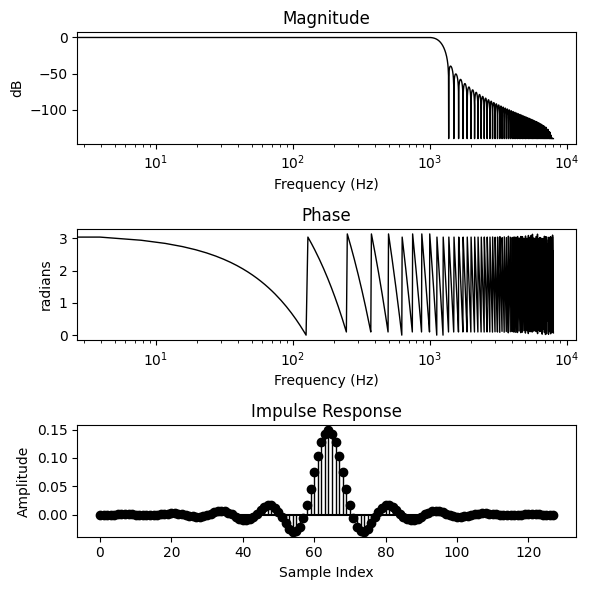

In [22]:
ir_length = 128

H_target = torch.cat((
    torch.ones(10),
    torch.zeros(ir_length // 2 + 1 - 10),
))
h_zero_phase = torch.fft.irfft(H_target)
h_s = torch.roll(h_zero_phase, ir_length // 2)
window = torch.hann_window(ir_length)
h = window * h_s
bode_plot(h, 4096)

Great! We have designed a linear phase filter which approximates our desired magnitude response. Note that we specified a response of length $L / 2 + 1$, not of $L$. This is because our desired impulse response is real valued, and so its spectrum is conjugate-symmetric around the Nyquist. We can thus use the more efficient `torch.fft.irfft`.

Let's try to learn a magnitude response using this differentiable design procedure. This time we'll define a slightly more challenging task: given a signal containing a mixture of sinusoidal components, extract a single frequency component.

First, we'll wrap our differentiable design procedure in a function.

In [23]:
def fir_window_design(
    target_magnitude_response: torch.Tensor,
    window_fn: Callable = torch.hann_window,
) -> torch.Tensor:
    ir_length = (target_magnitude_response.shape[-1] - 1) * 2
    
    h_zero_phase = torch.fft.irfft(target_magnitude_response)
    h_causal = torch.roll(h_zero_phase, ir_length // 2)
    window = window_fn(ir_length)
    h = window * h_causal
    return h

Next, we'll define our task by specifying the input and target signals.

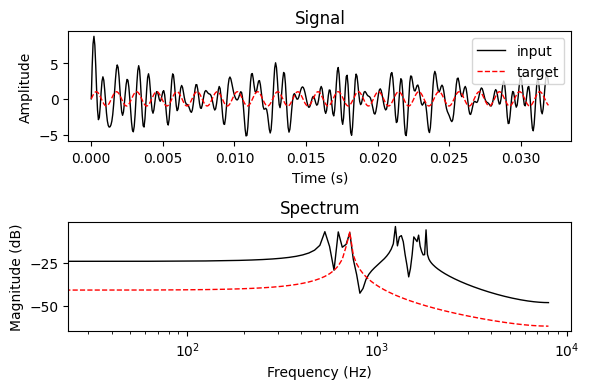

In [24]:
N = 512
num_components = 10
freqs = torch.empty(num_components).uniform_(0, 1.0)
n = torch.arange(N)
components = torch.sin(freqs[:, None] * n[None])

input_signal = components.sum(dim=0)
target_signal = components[0]

plot_signal_and_spectrum([input_signal, target_signal], labels=["input", "target"])

Then, we'll define a frequency domain loss function which takes distances only between magnitude spectra.

In [25]:
def fft_loss(a: torch.Tensor, b: torch.Tensor):
    A = safe_abs(torch.fft.rfft(a))
    B = safe_abs(torch.fft.rfft(b))

    return nn.functional.l1_loss(A, B)

Finally, we will initialise our filter...

In [26]:
ir_length = 64
predicted_filter_response = torch.randn(ir_length // 2 + 1, requires_grad=True)

And we are ready to optimise!

In [27]:
optimizer = torch.optim.Adam([predicted_filter_response], lr=1e-3)
criterion = fft_loss

steps = 20000
interval = 1000

for step in range(steps):
    predicted_ir = fir_window_design(predicted_filter_response)
    predicted_signal = apply_conv1d_fir(input_signal, predicted_ir)
    
    loss = criterion(target_signal, predicted_signal)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if step % interval == 0:
        print(f"Step {step}: loss {loss.item():.4f}")

Step 0: loss 7.3183
Step 1000: loss 2.1300
Step 2000: loss 1.4338
Step 3000: loss 1.3693
Step 4000: loss 1.3234
Step 5000: loss 1.3020
Step 6000: loss 1.2826
Step 7000: loss 1.2640
Step 8000: loss 1.2482
Step 9000: loss 1.2347
Step 10000: loss 1.2244
Step 11000: loss 1.2132
Step 12000: loss 1.2015
Step 13000: loss 1.1899
Step 14000: loss 1.1791
Step 15000: loss 1.1694
Step 16000: loss 1.1617
Step 17000: loss 1.1544
Step 18000: loss 1.1471
Step 19000: loss 1.1412


We seem to be converging on *something*... Let's check it out — first we plot the predicted signal against the target signal.

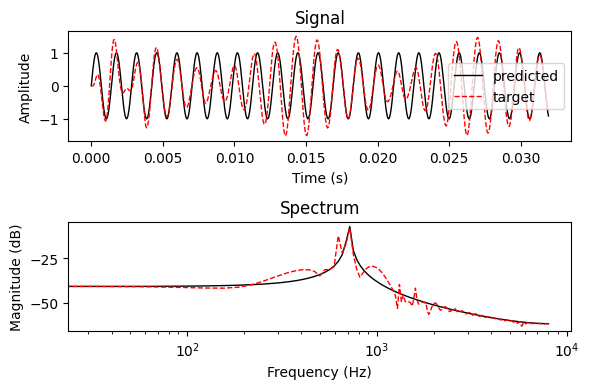

In [28]:
plot_signal_and_spectrum([target_signal, predicted_signal], labels=["predicted", "target"])

Not bad! We appear to be getting close to extracting the target frequency component. Now let's look at the filter we have learnt.

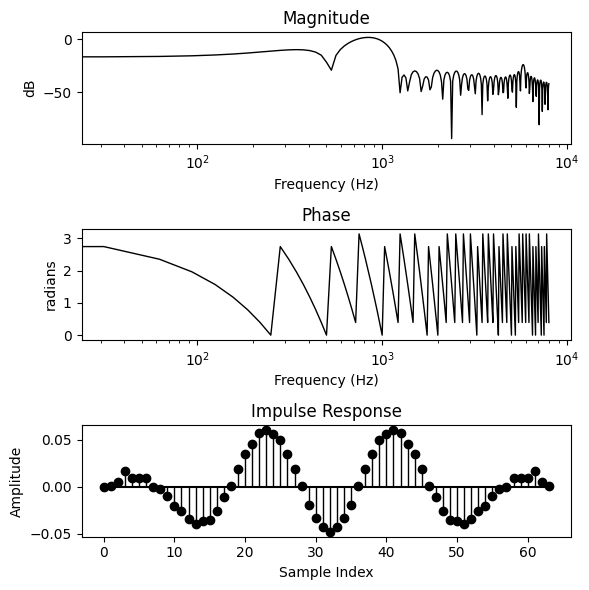

In [29]:
bode_plot(predicted_ir, N)

## Time-Varying FIR Filters

In the context of synthesis we often wish to produce sounds that change over time, and so we would ideally like to be able to vary the filter response. For example, in Engel et al.'s differentiable harmonic-plus-noise synthesiser {cite}`engel_ddsp_2020`, the frequency sampling technique we implemented in the previous section is applied to a time series of frequency responses, which are applied to overlapping segments of incoming white noise signal. These filtered segments are windowed and recombined using overlap-add (OLA) to produce the final signal.

We will re-implement this time-varying filtered noise synthesiser here. We first produce the local filter impulse responses using the function we defined above. We then apply these to the input signal using circular convolution in the frequency domain multiplication.

In [30]:
def time_varying_fir(
    input_signal: torch.Tensor,  # [time]
    target_filter_responses: torch.Tensor,  # [frames, ir_length / 2 + 1]
    n_fft: int,
    hop_length: int,
    filter_window_fn: Callable = torch.hann_window,
    ola_window_fn: Callable = torch.hann_window,
) -> torch.Tensor:
    # design the filters
    filter_irs = fir_window_design(target_filter_responses, filter_window_fn)

    num_frames, ir_length = filter_irs.shape
    signal_length = input_signal.shape[0]

    # compute the STFT of the signal
    signal_spectrum = torch.stft(
        input_signal,
        n_fft=n_fft,
        hop_length=hop_length,
        return_complex=True,
    )

    # zero pad the filters and compute their frequency responses
    pad_amount = n_fft - ir_length
    padded_filters = nn.functional.pad(filter_irs, (0, pad_amount))
    filter_responses = torch.fft.rfft(padded_filters, dim=-1).T

    # apply the filters by circular convolution in the freq. domain
    filtered_frames = filter_responses * signal_spectrum

    # take the ISTFT, overlap-adding the resulting frames
    ola_window = ola_window_fn(n_fft)    
    filtered_signal = torch.istft(
        filtered_frames,
        n_fft=n_fft,
        hop_length=hop_length,
        length=signal_length,
        window=ola_window
    )
    return filtered_signal

To test this implementation, let's use an audio signal. We'll load a short snippet of a percussion loop.

In [101]:
length_in_seconds = 1.0
signal_length = int(length_in_seconds * SAMPLE_RATE)

target_signal, sr = torchaudio.load("../audio/perc_loop.wav")

target_signal = target_signal[0]
target_signal = torchaudio.functional.resample(target_signal, sr, SAMPLE_RATE)
target_signal = target_signal[:signal_length]

ipd.Audio(target_signal, rate=SAMPLE_RATE)

Then, we'll randomly initialise our filterbank and apply it to a white noise signal (warning: likely to be loud and unpleasant)

Note that in `time_varying_fir` we zero pad the impulse response to match the length of `n_fft`, allowing us to set these to two different lengths.

In [106]:
n_fft = 128
hop_length = 64
ir_length = 33
n_filters = signal_length // hop_length + 1

predicted_filters = torch.randn(n_filters, ir_length // 2 + 1, requires_grad=True)
input_signal = torch.empty(signal_length).uniform_(-1, 1)

with torch.no_grad():
    predicted_signal = time_varying_fir(input_signal, predicted_filters, n_fft, hop_length)

ipd.Audio(predicted_signal, rate=SAMPLE_RATE)

As our filters are time-varying, we'll need a time-varying loss. It is common with DDSP to use a multi-resolution STFT loss, but for simplicity's sake we will use a single STFT scale.

In [103]:
def stft_loss(
    a: torch.Tensor, 
    b: torch.Tensor,
    n_fft: int,
    hop_length: int,
):
    A = torch.stft(a, n_fft=n_fft, hop_length=hop_length, return_complex=True)
    B = torch.stft(b, n_fft=n_fft, hop_length=hop_length, return_complex=True)

    A = safe_abs(A)
    B = safe_abs(B)
    return nn.functional.l1_loss(A, B)

Finally, we optimise the filter responses by gradient descent.

In [104]:
optimizer = torch.optim.Adam([predicted_filters], lr=1e-3)
criterion = partial(stft_loss, n_fft=n_fft, hop_length=hop_length)

steps = 15000
interval = 1000

for step in range(steps):
    predicted_signal = time_varying_fir(input_signal, predicted_filters, n_fft=n_fft, hop_length=hop_length)
    
    loss = criterion(target_signal, predicted_signal)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if step % interval == 0:
        print(f"Step {step}: loss {loss.item():.4f}")

Step 0: loss 3.8299
Step 1000: loss 0.7883
Step 2000: loss 0.1905
Step 3000: loss 0.1191
Step 4000: loss 0.1052
Step 5000: loss 0.1012
Step 6000: loss 0.0995
Step 7000: loss 0.0987
Step 8000: loss 0.0981
Step 9000: loss 0.0976
Step 10000: loss 0.0972
Step 11000: loss 0.0970
Step 12000: loss 0.0967
Step 13000: loss 0.0965
Step 14000: loss 0.0964


Let's listen to the audio this produces...

In [105]:
print("Predicted")
ipd.display(ipd.Audio(predicted_signal.detach(), rate=SAMPLE_RATE))
print("Target")
ipd.display(ipd.Audio(target_signal.detach(), rate=SAMPLE_RATE))

Predicted


Target


Not bad at all!

## Conclusion

This was a whirlwind tour of differentiable implementations of finite impulse response filters. Differentiable FIR filters have been used for applications from monophonic instrument modelling {cite}`engel_ddsp_2020`, through maximum voice frequency estimation {cite}`wang_neural_2019`, to sound effect generation {cite}`barahona-rios_noisebandnet_2023`. For further information, we refer readers to a recent review on differentiable digital signal processing {cite}`hayes_review_2023`.